### **Basics of Magnetic Resonance Imaging (MRI)**
MRI is an important *diagnostic* tool for visulaizing the soft tissues of the body. The main objective is to map the internal body structures which are hidden by the skin and bones. This helps in diagnosis and proper treatment without a need of an external surgery for analysis.

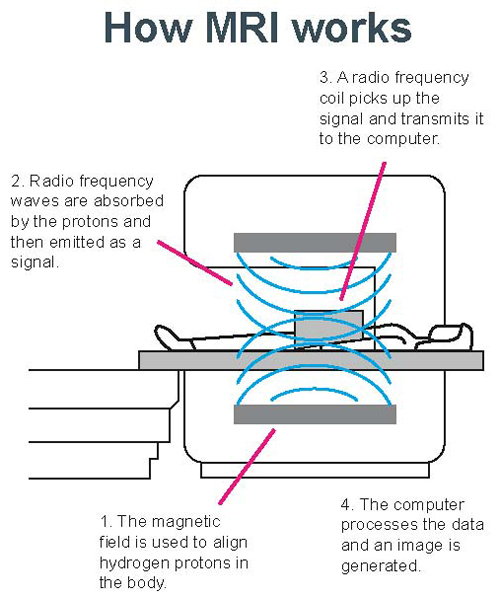

#### **Working Methodology**
* Our body is made up of water molecules.
* MRI use a powerful magnetic field to align the protons of the water molecules of the tissues which are otherwise randomly orientated.
* Further an external RF signal is used for the perturbation of this alignment.
* As the nuclei is relieved an RF energy is emitted which is measured.
* These frequency signals are converted using Fourier transform for further analysis.


### **RSNA-MICCAI Brain Tumor Radiogenomic Classification**
* *Glioblastoma* is a malignant tumor in the brain which is the most common form of brain cancer in adults and with the worst prognosis.
* A specific genetic sequence in the tumor known as MGMT promoter methylation is a favorable prognostic factor.
* The current competition requires to predict the genetic subtype of glioblastoma using MRI scans to train and test model to detect the presence of MGMT.

### **Import Modules**

In [ ]:
import os
import sys
import cv2
import torch
import random
import warnings
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import pydicom as pdcm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import KFold

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = 12, 6 

### **Analysis of the given MRI dataset**

In [ ]:
main_path = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification"
for files in os.listdir(main_path):
    print(files)

The train folder consists of sub folders which are the independent cases represented by a five digit number. For each case, four sub-folder exists which correspond to each of the **structural multi-parametric MRI** scans in **DICOM** format.  

##### **Structural multi-parametric MRI(mpMRI)**
MP-MRI, an important type of MRI which creates a more informative picture compared to a single MRI, since it combines different types of images. There can different variants but the current dataset includes:
* Fluid Attenuated Inversion Recovery (FLAIR)
* T1-weighted pre-contrast (T1w)
* T1-weighted post-contrast (T1Gd)
* T2-weighted (T2)

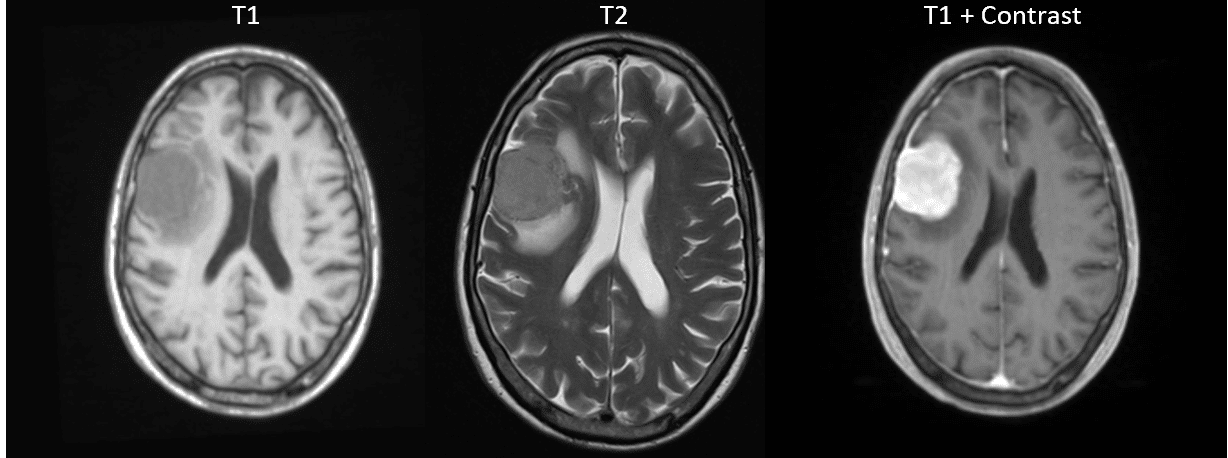
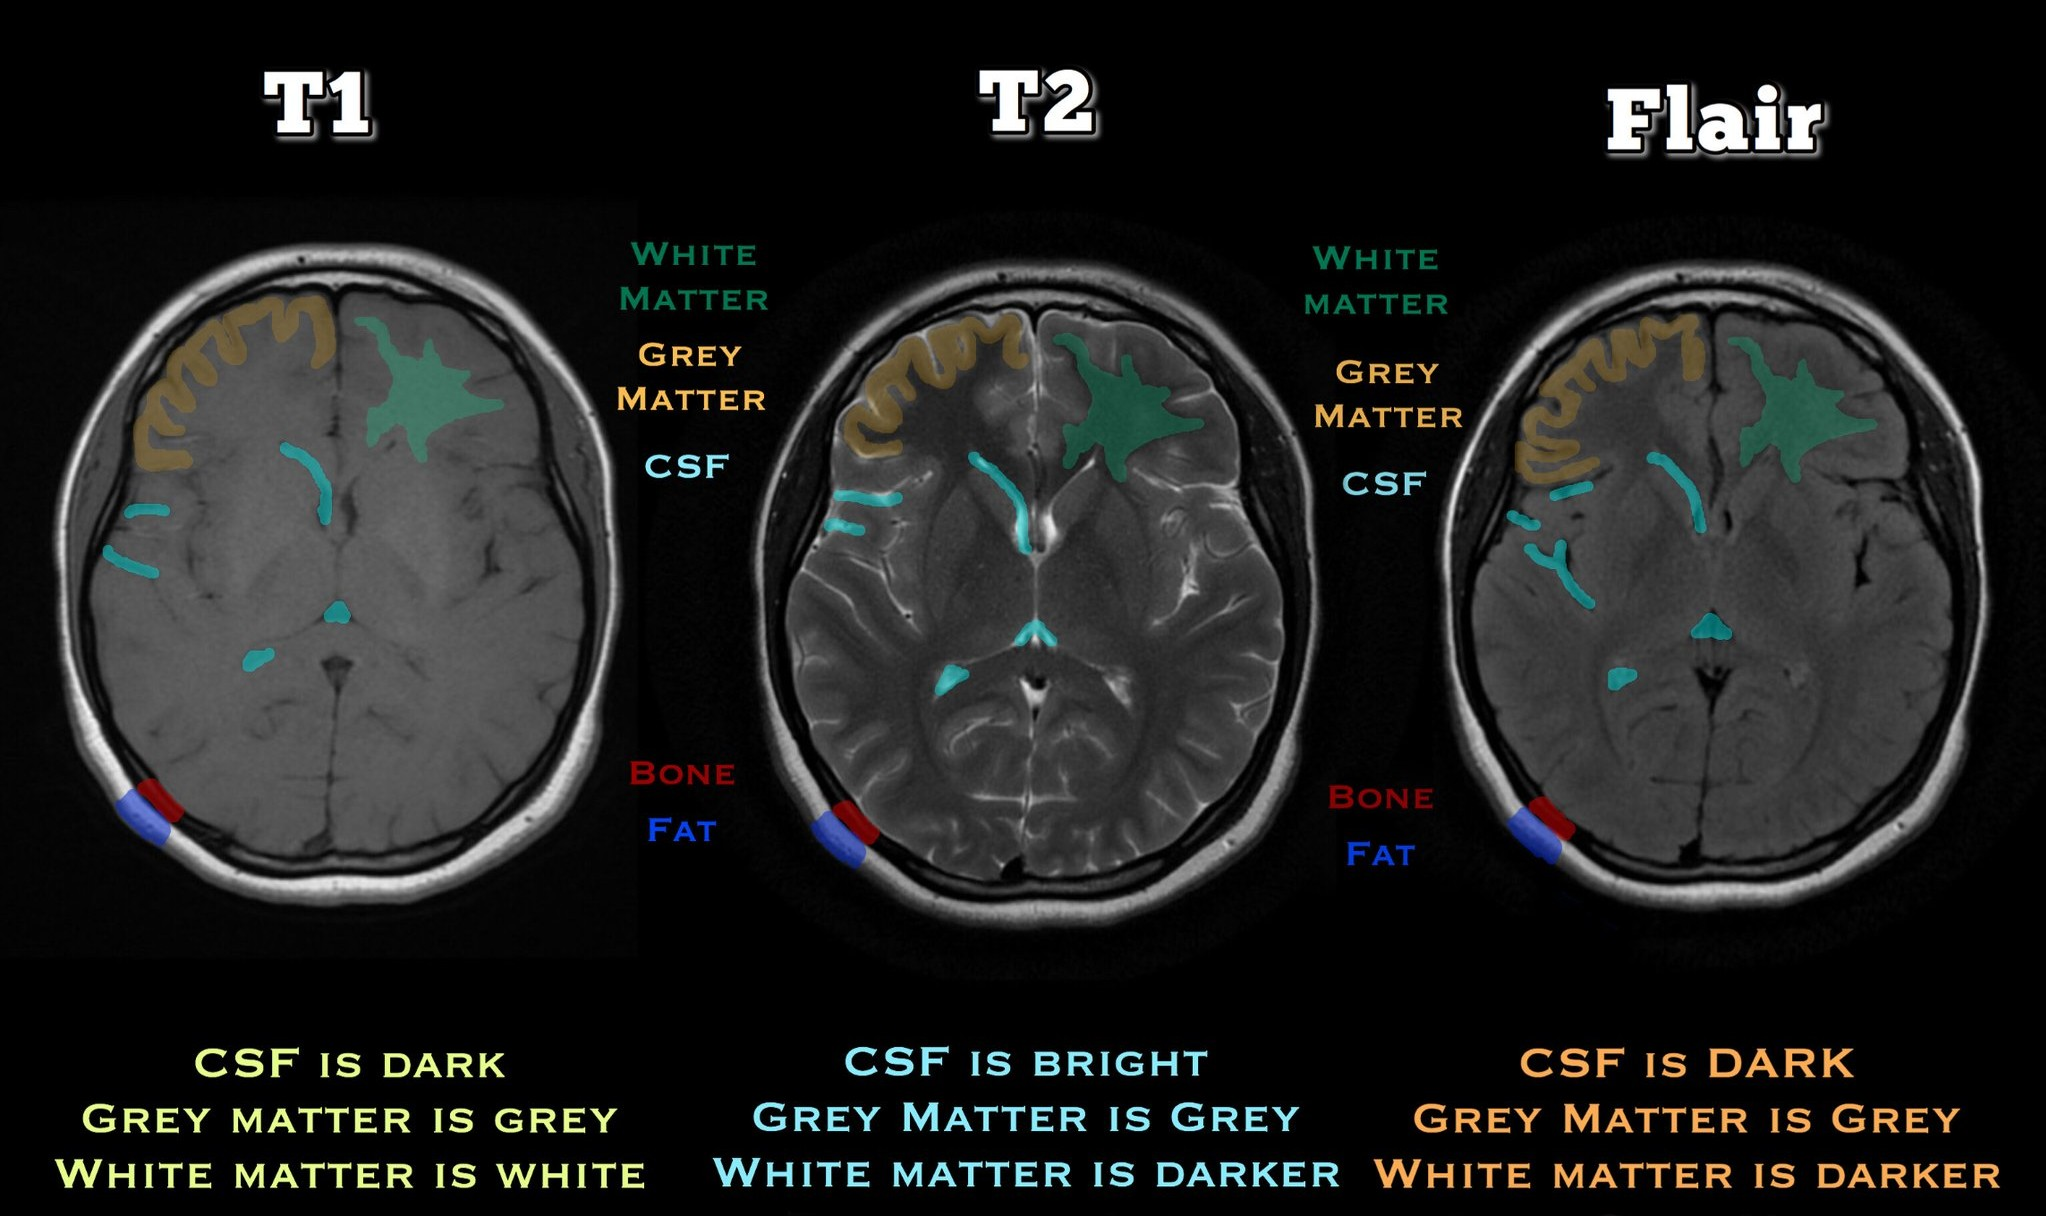

These different categories are mostly due to the ability of MR scanners to gather information depending on the pulse sequence. Each one differ by intensity which represents different tissues.

##### **Digital Imaging and Communication in Medicine (DICOM)**
A de-facto standard format with a set of well defined rules used for storing and transmitting medical images.

### **Filter Irrelevant Data**
As shared in different notebooks the dataset with ids (109, 123, 709) are redundant, hence they are removed using the following code.

In [ ]:
train_df = pd.read_csv(f"{main_path}/train_labels.csv")
test_df = pd.read_csv(f"{main_path}/sample_submission.csv")

for ids in [109, 123, 709]:
    train_df.drop(train_df[train_df["BraTS21ID"]==ids].index, inplace=True)    

### **Adding Metadata**
Additional Informations like count of images of all the variants which are useful for stastical analysis is added to the previous dataframe. This also helps in preventing errors while building the input data for training.

In [ ]:
mp_mri_type = ['FLAIR', 'T1w', 'T1wCE', 'T2w']

def build_df(dataframe, train=True):
    dir_type = ("train" if train else "test")
    for mp_type in mp_mri_type:
        count = [] 
        for ids in dataframe["BraTS21ID"]:
            fid = str(ids).zfill(5)
            file = os.listdir(f"{main_path}/{dir_type}/{fid}/{mp_type}")
            count.append(len(file))
        dataframe[mp_type] = count    
    return dataframe

train_df = build_df(train_df, train=True)
test_df = build_df(test_df, train=False)

train_df["CountImages"] = train_df["FLAIR"] + train_df["T1w"] + train_df["T2w"] + train_df["T1wCE"]
test_df["CountImages"] = test_df["FLAIR"] + test_df["T1w"] + test_df["T2w"] + test_df["T1wCE"]

In [ ]:
train_df.describe()

In [ ]:
test_df.describe()

The above analysis show that the minimum total image count for a given subject taking into account all the variants is **80 for *train* and 92 for *test***. This is important as we can not exceed beyond these values while building the input data (for the given network architecture). For training for a single subject images from all the variants are taken to build a dataset of the form of (NUM_SAMPLES, IMG_SIZE, IMG_SIZE), where NUM_SAMPLES = 64.

<span style="color:red">**NOTE:** NUM_SAMPLES is not batch size, consider it as equivalent to frames in a video data.</span>


*MGMT_value* is the label where 1 stands for presence and 0 for absence of MGMT in the given subject

In [ ]:
sns.countplot(x='MGMT_value', data=train_df)
plt.show()

The current dataset does not suffer from **data imbalance problem**, since there is a very small difference between the count of the samples of the two classes.

### **Hyperparameters**

In [ ]:
IMG_SIZE = 64
BATCH_SIZE = 64
NUM_SAMPLES = 64
EPOCHS = 9
LRate = 0.005
SEED = 42

### **Feature Engineering**
* When using a black box tool like Deep Learning, it is generally left to the model to extract the important features from the dataset and predict the relevant class. 
* But there are irrelevant noisy data which worsens the trainnig.
* More data does not always mean better model.
* Such data should be removed beforehand to improve performance.
* In the current MRI classification, the initial and last time stamps consists of many **complete black frames** and **small blobs** which does not help in prediction.
* For a given input data only the top 64 frames (all 4 variants) are used which has highest average pixel intensity.
* This condition assumes images with the highest average has full slice of brain image leading to better model training.

In [ ]:
def sort_paths(path):
    return sorted(path, key=lambda x: int(x.split('-')[1].split('.')[0]))

def read_dicom_img(dataset_dir, file_id):
    file_path = f"{main_path}/{dataset_dir}/{file_id.zfill(5)}"
    final_img = []
    for mri_type in mp_mri_type:
        final_file_path = f"{file_path}/{mri_type}"
        sorted_files = sort_paths(os.listdir(final_file_path))
        
        for i in range(len(sorted_files)) :
            data = pdcm.dcmread(f"{final_file_path}/{sorted_files[i]}")
            img_data = data.pixel_array
            img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
            img_data = (img_data - np.min(img_data))/ (np.max(img_data)+1)
            final_img.append(img_data)            
    
    final_img = sorted(final_img, key=lambda x: np.mean(x), reverse=True)[:NUM_SAMPLES]
    return np.asarray(final_img)

### **Image Visualization**
Showing some sample images and its label for each subject

In [ ]:
def show_img(data, axis, row):
    for i in range(6):
        axis[row][i].imshow(data[i], cmap="gray") 
        axis[row][i].set_axis_off()

In [ ]:
dataset_dir = "train"
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(10,15))
for index in range(5):
    id = train_df['BraTS21ID'][index]
    all_imgs = read_dicom_img(dataset_dir, str(id))
    ax[index][2].set_title(f"MGMT: {('Present' if train_df['MGMT_value'][index] else 'Absent')}", 
                           fontsize=15, fontweight ="bold")
    show_img(all_imgs, ax, index)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show() 
    

### **Data Loader**

In [ ]:
class MRIdata(Dataset):
    def __init__(self, path_to_data, train=True, transform=None):
        self.data = pd.read_csv(path_to_data)
        self.labels = self.data['MGMT_value']
        self.transform = transform
        self.train = train
        self.train_dir = ("train" if train else "test")

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        inp_data = read_dicom_img(self.train_dir, str(self.data['BraTS21ID'][index]))
        inp_data = self.transform(inp_data).permute(1,0,2)
    
        if self.train:
            labels = torch.tensor(self.labels[index], dtype=torch.float)
            final_data = {"features": torch.tensor(inp_data).float(),
                          "labels": labels}
        else:
            final_data = {"features": torch.tensor(inp_data).float(),
                         "IDs": self.data['BraTS21ID'][index]}
        
        return final_data

In [ ]:
transforms = T.Compose([T.ToTensor()])

data = MRIdata(f"{main_path}/train_labels.csv", transform=transforms)

train_loader = DataLoader(data, shuffle=True, batch_size=BATCH_SIZE)

### **Network Architecture**

In [ ]:
class MRINet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(self.conv_layer(in_chan=64, out_chan=128),
                                  self.conv_layer(in_chan=128, out_chan=128),
                                  self.conv_layer(in_chan=128, out_chan=256))
        
        self.fc = nn.Sequential(nn.Linear(9216,512),
                                nn.Dropout(p=0.15),
                                nn.Linear(512, 1))
        
    
    def conv_layer(self, in_chan, out_chan):
        conv_layer = nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size=(3,3), padding=0),
            nn.LeakyReLU(),
            nn.MaxPool2d((2,2)),
            nn.BatchNorm2d(out_chan))
        
        return conv_layer    
           
    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)    
        return out

### **Training**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = MRINet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=LRate)

for epoch in range(EPOCHS):
    total_loss = 0.0
    count = 0
    for indx, data in enumerate(train_loader, 0):
        inputs, labels = data["features"].to(device), data["labels"].to(device)
        optimizer.zero_grad()
        outputs = net(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        total_loss += loss.detach().item()
        optimizer.step()
        
        count += 1
    
    print(f"Epoch:{epoch}/{EPOCHS} - Loss:{total_loss/count}")

print("Training Complete")    
        

### **Inference**

In [ ]:
test_data = MRIdata(f"{main_path}/sample_submission.csv", train=False,
                    transform=transforms)

test_loader = DataLoader(test_data, shuffle=False, batch_size=1)

preds = []

for query in test_loader:
    with torch.no_grad():
        output = net(query["features"].to(device))
        output = torch.sigmoid(output).cpu().numpy().squeeze()
        preds.append(output)
    

### **Submission**

In [ ]:
submission = pd.read_csv(f"{main_path}/sample_submission.csv", index_col="BraTS21ID")
submission["MGMT_value"] = preds
submission["MGMT_value"].to_csv("submission.csv")